In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import torch

from scipy.stats import binom_test

import sbibm

from sbibm.utils.io import get_ndarray_from_csv
from sbi.analysis import pairplot
from sbi.utils.metrics import c2st
from utils import compile_df, plot_bar

In [2]:
# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

seed 223174


In [3]:
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

## Load benchmarking results

In [4]:
df = pd.concat([
    compile_df("../data/results/ddm-benchmarking/mnle/100-1000-trials/2021-10-25/11-01-18/"), # MNLE 100, 1000
    compile_df("../data/results/ddm-benchmarking/lan/100-1000-trials/2021-10-24/04-03-04/"), # LAN 100, 1000
])

# Exclude results for 1000-trial observations (observation indices > 300)
df.num_observation = df.num_observation.astype(int)
df = df[df.num_observation <=300]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
# get posterior sample mean and variance
N = 100
M = 1000
dim_parameters = 4
nle_samples = np.zeros((N, M, dim_parameters))
lan_samples = np.zeros((N, M, dim_parameters))
true_samples = np.zeros((N, M, dim_parameters))
true_params = np.zeros((N, dim_parameters))

for ii in range(N):
    # Offset to account for the fact that observations with 100 trials start at index 200
    obsi = ii + 1 + 200
    dd = df[df.num_observation==obsi]

    nle_samples[ii,] = get_ndarray_from_csv(dd[dd.algorithm=="NLE"].path.values[0]+"/posterior_samples.csv.bz2")[:M]
    lan_samples[ii,] = get_ndarray_from_csv(dd[dd.algorithm=="LAN-KDE"].path.values[0]+"/posterior_samples.csv.bz2")[:M]
    true_samples[ii,] = task.get_reference_posterior_samples(obsi).numpy()[:M]
    # get tho
    true_params[ii,] = task.get_true_parameters(obsi).numpy()

In [6]:
# load new results with smaller budgets.
with open("../data/results/lan_10_5_ours_posterior_samples_100x100iid.p", "rb") as fh:
    lan_samples_5 = torch.stack(pickle.load(fh)).numpy()

with open("../data/results/lan_10_8_ours_posterior_samples_100x100iid.p", "rb") as fh:
    lan_samples_8 = torch.stack(pickle.load(fh)).numpy()

# NOTE: replace old LAN samples with new one as the new LANs are better.
with open("../data/results/lan_10_11_posterior_samples_100x100iid.p", "rb") as fh:
    lan_samples = torch.stack(pickle.load(fh)).numpy()


### Post-hoc calculate posterior metrics

In [7]:
meanerr = np.zeros((N, 4))  # 3 LANs, 1 MNLE
varerr = np.zeros_like(meanerr)
dispersion = np.zeros_like(meanerr)
estimation_error = np.zeros_like(meanerr)  # one more for reference error
estimation_error_reference = ((true_params - true_samples.mean(1))**2).mean(-1)
recalculate_c2st = False

# NOTE: abs differences for mean and var, normalized by true std or var. take mean over param dims (axis -1)
for i, s in enumerate([lan_samples_5, lan_samples_8, lan_samples, nle_samples]):
    meanerr[:, i] = np.mean(abs(true_samples.mean(1) - s.mean(1)) / true_samples.std(1), -1)  
    varerr[:, i] = np.mean(abs(true_samples.var(1) - s.var(1)) / true_samples.var(1), -1)
    estimation_error[:, i] = np.mean((true_params - s.mean(1))**2, -1)

# Calculate c2st for lower LAN budgets
if recalculate_c2st:
    c2st_scores = np.zeros((N, 4))
    for ii in range(N):
        c2st_scores[ii, 0] = c2st(torch.tensor(lan_samples_5[ii,]), torch.tensor(true_samples[ii,]))
        c2st_scores[ii, 1] = c2st(torch.tensor(lan_samples_8[ii,]), torch.tensor(true_samples[ii,]))
        c2st_scores[ii, 2] = c2st(torch.tensor(lan_samples[ii,]), torch.tensor(true_samples[ii,]))
        c2st_scores[ii, 3] = c2st(torch.tensor(nle_samples[ii,]), torch.tensor(true_samples[ii,]))
    with open("../data/results/c2st_scores_all_100iid-obs.p", "wb") as fh:
        pickle.dump(c2st_scores, fh)
else: 
    with open("../data/results/c2st_scores_all_100iid-obs.p", "rb") as fh:
        c2st_scores = pickle.load(fh)

### And add to data frame

In [8]:
df = df.sort_values(by=["num_observation", "algorithm"])
# put in mnle scores.
c2st_scores[:, 3] = df.loc[:, "C2ST"].values[1::2]

### Load posterior samples

In [9]:
obs = 211
labels = ["LAN-KDE", "NLE"]
cols = ["MEANERR", "VARERR", "ESTI", "C2ST"]
paths = []

# df = df100
for alg in labels:
    idx = df[df.num_observation==obs].algorithm == alg
    p = df[df.num_observation==obs].loc[idx, "path"].values
    [paths.append(pi) for pi in p]

ss = [
    sbibm.get_task("ddm").get_reference_posterior_samples(obs)
     ] + [get_ndarray_from_csv(path+"/posterior_samples.csv.bz2") for path in paths]

/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/anaconda3/envs/mnle/lib/python3.7/site-packages/ipyk

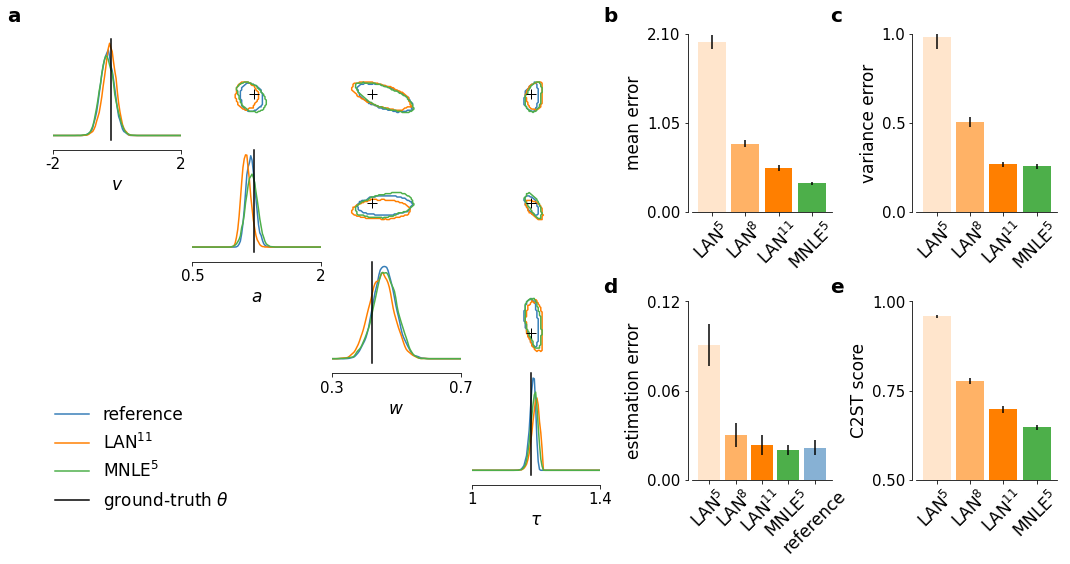

In [10]:
plt.style.use('plotting_settings.mplstyle')
fig = plt.figure(figsize=(18, 8))
outer_grid = fig.add_gridspec(1, 2, wspace=0.2, hspace=0, width_ratios=[.6, .4])
# Plotting settings
rotation = 45
y_axis_setoff = -0.03
labels = [
    r"LAN$^5$", 
    r"LAN$^8$", 
    r"LAN$^{11}$", 
    r"MNLE$^5$",
]

alphas = [1, 0.2, 0.6, 1, 1]
plot_colors = [colors[0], colors[1], colors[1], colors[1], colors[2]]

# posterior samples
num_plots = 4
inner_grid = outer_grid[0, 0].subgridspec(num_plots, num_plots, wspace=0.09, hspace=0)
ax1 = inner_grid.subplots()  # Create all subplots for the inner grid.
fix, ax1 = pairplot(ss, 
         points=sbibm.get_task("ddm").get_true_parameters(obs)[:M], 
         limits=[[-2, 2], [0.5, 2.0], [.3, .7], [1., 1.4]], 
         ticks = [[-2, 2], [0.5, 2.0], [.3, .7], [1., 1.4]], 
         samples_colors=colors[:3], 
         diag="kde",
         upper="contour",
         kde_offdiag=dict(bw_method=.2, bins=100),
         kde_diag=dict(bw_method=.12, bins=100),
         contour_offdiag=dict(levels=[0.95], percentile=True),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         fig=fig, 
         axes=ax1,
         labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"],
        );
plt.sca(ax1[0, 0])
plt.legend(["reference", r"LAN$^{11}$", r"MNLE$^5$", r"ground-truth $\theta$"], 
           bbox_to_anchor=(-.1, -2.2), 
           loc=2)

# posterior metrics
inner_grid = outer_grid[0, 1].subgridspec(2, 2, wspace=.6, hspace=.5, )
ax2 = inner_grid.subplots()  # Create all subplots for the inner grid.

plt.sca(ax2[0, 0])
pos = []
width = 0.1
pos_scale = 0.12
for ii in range(4):
    pos.append(ii*pos_scale)
    plot_bar(pos[ii], width, meanerr[:, ii], label=labels[ii], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels, rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"]);
plt.ylabel("mean error")
# plt.yscale("log")
plt.ylim(0, 2.1)
plt.yticks(np.linspace(0, 2.1, 3))
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))


plt.sca(ax2[0, 1])
for ii in range(4):
    plot_bar(pos[ii], width, varerr[:, ii], label=labels[ii], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels, rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"]);
plt.ylabel("variance error")
# plt.yscale("log")
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 3))
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

plt.sca(ax2[1, 1])
for ii in range(4):
    plot_bar(pos[ii], width, c2st_scores[:, ii], label=labels[ii], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels, rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"]);
plt.ylabel("C2ST score")
plt.ylim(0.5, 1)
plt.yticks(np.linspace(0.5, 1, 3))
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

plt.sca(ax2[1, 0])
for ii in range(4):
    plot_bar(pos[ii], width, estimation_error[:, ii], label=labels[ii], color=plot_colors[ii+1], alpha=alphas[ii+1])

pos.append(pos[-1] + pos_scale)
plot_bar(pos[-1], width, estimation_error_reference, label="reference", color=colors[0])
plt.xticks(pos, labels + ["reference"], rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"]);
plt.ylabel("estimation error")
plt.ylim(0, .12)
plt.yticks(np.linspace(0, .12, 3))
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

weight = "bold"
fontsize = 20
y1 = 0.92
x1 = 0.09
dx = 0.635
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.46, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1, "c", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 0.46, y1 - 0.47, "d", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1 - 0.47, "e", fontsize=fontsize, fontweight=weight)

plt.tight_layout();

In [11]:
fig.savefig("figures/Figure3-MNLE-LAN-posterior-comparison.pdf", dpi=400, bbox_inches="tight");
fig.savefig("figures/Figure 3.pdf", dpi=400, bbox_inches="tight");

### Means and pairwise comparison tests as report in the paper

In [12]:
# helper fun for comparisons
def num_a_greater_b_and_binom_test(a, b, num_observations=100):
    num_a_greater_b = (a>b).sum()
    return num_a_greater_b, binom_test(num_a_greater_b, num_observations, 0.5)

In [13]:
meanerr.shape

(100, 4)

In [14]:
print("mean error")
for ll in meanerr.T[:-1]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=meanerr[:, -1])
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")
    
print("variance error")
for ll in varerr.T[:-1]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=varerr[:, -1])
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")
    
print("estimation error")
for ll in estimation_error.T[:-1]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll-estimation_error_reference, 
                                                               b=estimation_error[:, -1] - estimation_error_reference)
    print(f"LAN / MNLE != REF: {num_greater}, p={binom_pvalue}")
    
print("C2st")
for ll in c2st_scores.T[:-1]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=c2st_scores[:, -1])
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")

mean error
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 90, p=3.0632901754379845e-17
LAN > MNLE: 67, p=0.0008737198369123724
variance error
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 93, p=2.726143732806038e-20
LAN > MNLE: 58, p=0.13321061920721386
estimation error
LAN / MNLE != REF: 86, p=8.284451872080075e-14
LAN / MNLE != REF: 67, p=0.0008737198369123724
LAN / MNLE != REF: 66, p=0.0017899303914868528
C2st
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 91, p=3.3220489794536525e-18
LAN > MNLE: 68, p=0.00040877716742681523


In [15]:
# LAN-5, LAN-8, LAN-11, MNLE
np.mean(meanerr, 0), np.std(meanerr, 0) / 10

(array([2.00374838, 0.80476577, 0.5154907 , 0.33721154]),
 array([0.08105902, 0.03973844, 0.03295723, 0.0184296 ]))

In [16]:
np.mean(varerr, 0), np.std(varerr, 0) / 10

(array([0.9824966 , 0.50452381, 0.26822651, 0.25560727]),
 array([0.06843193, 0.0258637 , 0.0127958 , 0.01434039]))

In [17]:
np.mean(c2st_scores, 0), np.std(c2st_scores, 0) / 10

(array([0.958465 , 0.777185 , 0.697685 , 0.6470285]),
 array([0.00436496, 0.00924426, 0.0099196 , 0.005812  ]))

In [18]:
estimation_error_reference.mean()

0.021535471347786325

In [19]:
np.mean(estimation_error, 0), np.std(estimation_error, 0) / 10 

(array([0.09063803, 0.03035263, 0.02364591, 0.02013474]),
 array([0.0139061 , 0.00811793, 0.00653278, 0.00339631]))

### Sign test whether MNLE or LAN has smaller mean error

In [20]:
smaller_err = (meanerr[:, -2] > meanerr[:, -1]).sum()
smaller_err, binom_test(smaller_err, 100, 0.5) < 1e-3

(67, True)

In [21]:
smaller_err = (varerr[:, -2] > varerr[:, -1]).sum()
smaller_err, binom_test(smaller_err, 100, 0.5)

(58, 0.13321061920721386)

In [22]:
smaller_err = (estimation_error[:, -2] > estimation_error[:, -1]).sum()
smaller_err, binom_test(smaller_err, 100, 0.5)

(66, 0.0017899303914868528)

### Sign test for smaller c2st

In [23]:
smallerc2st = (c2st_scores[:, -2] > c2st_scores[:, -1]).sum()
smallerc2st, binom_test(smallerc2st, 100, 0.5)

(68, 0.00040877716742681523)

# Figure 4: posterior calibration

Calculate SBC ranks post hoc from samples.

In [24]:
L = 1000
ranks = np.zeros((N, 4, 5)) # 4 params, 5 methods

for obsi in range(N):
    # rank tho under samples
    ranks[obsi, :, 0] = (true_samples[obsi, :L, ] < true_params[obsi,]).sum(0)
    ranks[obsi, :, 1] = (lan_samples_5[obsi, :L, ] < true_params[obsi,]).sum(0)
    ranks[obsi, :, 2] = (lan_samples_8[obsi, :L, ] < true_params[obsi,]).sum(0)
    ranks[obsi, :, 3] = (lan_samples[obsi, :L, ] < true_params[obsi,]).sum(0)
    ranks[obsi, :, 4] = (nle_samples[obsi, :L, ] < true_params[obsi,]).sum(0)

/home/janfb/anaconda3/envs/mnle/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


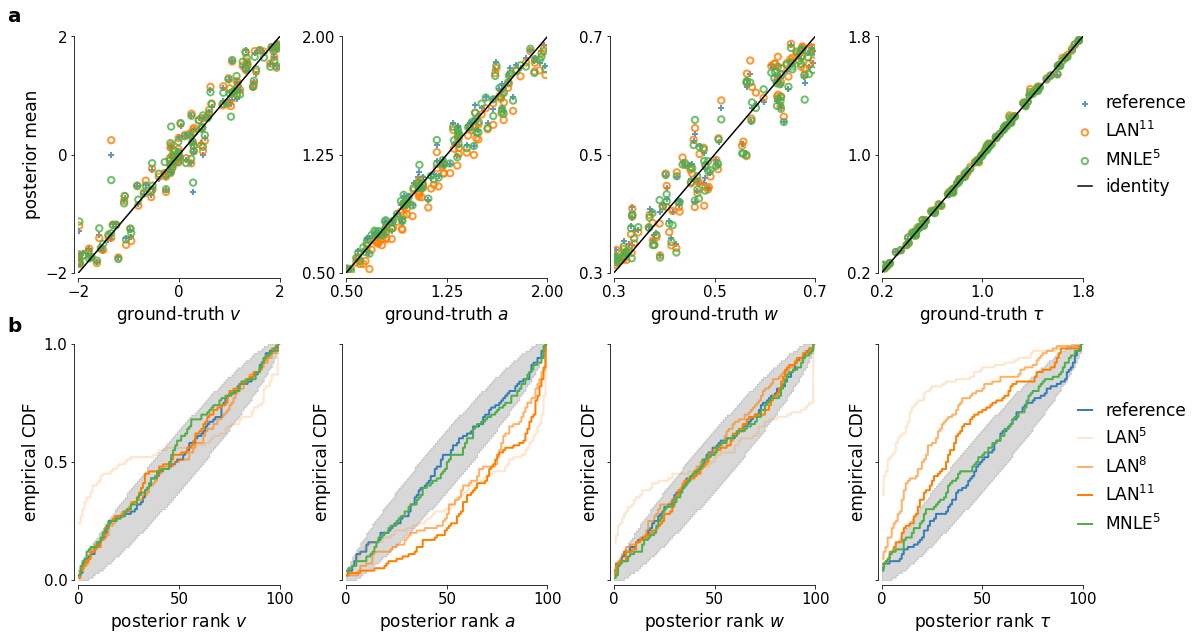

In [25]:
plt.style.use('plotting_settings.mplstyle')
fig, ax = plt.subplots(2, 4, figsize=(18, 10), 
                      gridspec_kw=dict(wspace=0.33, hspace=0.3))
# mpl.rcParams["legend.fontsize"] = 16
parameter_labels = [r"$v$", r"$a$", r"$w$", r"$\tau$"]
s = 40
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]
alphas = [1, 0.2, 0.6, 1, 1]
plot_colors = [colors[0], colors[1], colors[1], colors[1], colors[2]]
labels = [
    r"LAN$^5$", 
    r"LAN$^8$", 
    r"LAN$^{11}$", 
    r"MNLE$^5$",
]
linewidth = 2

for ii in range(4):
    # actual GT params
    truth = true_params[:, ii]
    plt.sca(ax[0, ii])
    plt.scatter(truth, true_samples.mean(1)[:, ii], s=s, color=colors[0], 
                label=fr"reference",            
                alpha=alpha,
                linewidths=linewidth,
                marker="+",
                )
    plt.scatter(truth, lan_samples.mean(1)[:, ii], s=s, color=colors[1], 
#                 label=fr"LAN, $R^2={np.corrcoef(truth, lan_samples.mean(1)[:, ii])[0, 1]**2:.2f}$",
                label=labels[-2],            
                alpha=alpha,
                linewidths=linewidth,
                facecolors="none",
               )
    plt.scatter(truth, nle_samples.mean(1)[:, ii], s=s, color=colors[2], 
#                 label=fr"NLE, $R^2={np.corrcoef(truth, nle_samples.mean(1)[:, ii])[0, 1]**2:.2f}$",
                label=labels[-1],
                linewidths=linewidth,
                alpha=alpha,      
                facecolors="none",
               )
    plt.plot(np.linspace(limits[ii][0], limits[ii][1], 100), 
             np.linspace(limits[ii][0], limits[ii][1], 100), color="k", label="identity")
    plt.ylim(limits[ii])
    plt.yticks(np.linspace(limits[ii][0], limits[ii][1], 3))

    plt.xlim(limits[ii])
    plt.xticks(np.linspace(limits[ii][0], limits[ii][1], 3))
    plt.xlabel("ground-truth " + parameter_labels[ii])
#     plt.ylabel([r"$\hat{v}$", r"$\hat{a}$", r"$\hat{w}$", r"$\hat{\tau}$"][ii])
    if ii == 0:
        plt.ylabel("posterior mean")
    if ii==3:
        plt.legend(loc=2, handlelength=0.8, bbox_to_anchor=(.9, .82));

repeats = 50
nbins = 100
from scipy.stats import binom
num_methods = 5
linewidth = 2

for ii in range(num_methods):
    for jj in range(4):
        plt.sca(ax[1, jj])
        hist, *_ = np.histogram(ranks[:, jj, ii], bins=nbins, density=False)
        histcs = hist.cumsum()
        plt.plot(np.linspace(0, nbins, repeats*nbins), 
                 np.repeat(histcs / histcs.max(), repeats), 
        #          label=labels[i], 
                 color=plot_colors[ii], 
                 alpha=alphas[ii], 
                 lw=linewidth,
                )

        if jj==3 and ii==num_methods-1:
            plt.legend(["reference"] + labels, loc=2, handlelength=0.8, bbox_to_anchor=(.9, .82))
        
        if ii==num_methods-1 and jj>0:
            plt.yticks(np.linspace(0, 1, 3), [])
        else:
            plt.yticks(np.linspace(0, 1, 3))
            plt.ylabel("empirical CDF")


        plt.ylim(0, 1)
        plt.xlim(0, nbins)
        plt.xticks(np.linspace(0, nbins, 3))
        plt.xlabel("posterior rank "+parameter_labels[jj])
        if ii==num_methods-1:
            # Construct uniform histogram.
            hb = binom(N, p=1 / nbins).ppf(0.5) * np.ones(nbins)
            hbb = hb.cumsum() / hb.sum()
            # avoid last value being exactly 1
            hbb[-1] -= 1e-9

            lower = [binom(N, p=p).ppf(0.005) for p in hbb]
            upper = [binom(N, p=p).ppf(0.995) for p in hbb]

            # Plot grey area with expected ECDF.
            plt.fill_between(x=np.linspace(0, nbins, repeats*nbins), 
                         y1=np.repeat(lower / np.max(lower), repeats), 
                         y2=np.repeat(upper / np.max(lower), repeats), 
                         color="grey", 
                         alpha=0.3)

# add y axes offset
axis_setoff = -0.02
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].spines["left"].set_position(("axes", axis_setoff))
        ax[i, j].spines["bottom"].set_position(("axes", axis_setoff))

weight = "bold"
fontsize = 20
y1 = 0.9
x1 = 0.07
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1 - 0.43, "b", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("figures/Figure4-MNLE-LAN-posterior-calibration.png", dpi=300, bbox_inches="tight");
fig.savefig("figures/Figure 4.pdf", dpi=400, bbox_inches="tight");

## Supplementary figures

### Posterior plots for lower LAN budgets

/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/anaconda3/envs/mnle/lib/python3.7/site-packages/ipyk

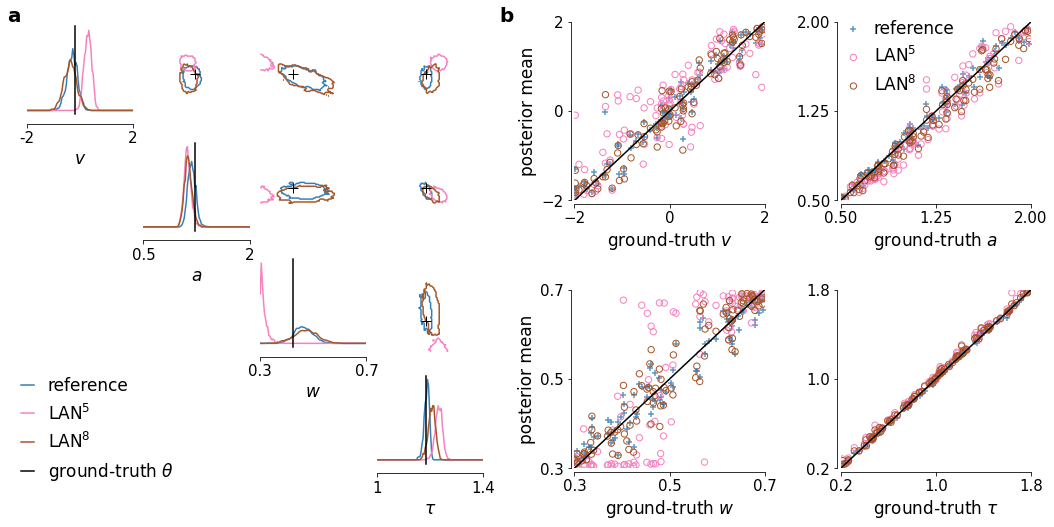

In [26]:
fig = plt.figure(figsize=(18, 8))
outer_grid = fig.add_gridspec(1, 2, wspace=0.2, hspace=0, width_ratios=[.5, .5])

num_plots = 4
inner_grid = outer_grid[0, 0].subgridspec(num_plots, num_plots, wspace=0.1, hspace=0.2)
ax1 = inner_grid.subplots()  # Create all subplots for the inner grid.

obs_idx = 10
kde_bins = 100
fix, ax1 = pairplot(
        [
            task.get_reference_posterior_samples(201 + obs_idx)[:M], 
            lan_samples_5[obs_idx], 
            lan_samples_8[obs_idx]
        ],
         points=sbibm.get_task("ddm").get_true_parameters(201 + obs_idx), 
         limits=[[-2, 2], [0.5, 2.0], [.3, .7], [1., 1.4]], 
         ticks = [[-2, 2], [0.5, 2.0], [.3, .7], [1., 1.4]], 
         samples_colors=colors[:1] + colors[3:5], 
         diag="kde",
         upper="contour",
         kde_diag=dict(bw_method=0.12, bins=kde_bins),
         kde_offdiag=dict(bw_method=.2, bins=kde_bins),
         contour_offdiag=dict(levels=[.95], percentile=True),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"],
         fig=fig, 
         axes=ax1,
        );
plt.sca(ax1[0, 0])
plt.legend(["reference", r"LAN$^{5}$", r"LAN$^8$", r"ground-truth $\theta$"], 
            handlelength=0.8,
           bbox_to_anchor=(-.2, -2.5), 
           loc=2);

# posterior metrics
inner_grid = outer_grid[0, 1].subgridspec(2, 2, wspace=.4, hspace=.5, )
ax2 = inner_grid.subplots()  # Create all subplots for the inner grid.

for ii in range(4):
    # actual GT params
    truth = true_params[:, ii]
    if ii<2:
        plt.sca(ax2[0, ii%2])
    else: 
        plt.sca(ax2[1, ii%2])

    plt.scatter(truth, true_samples.mean(1)[:, ii], s=s, color=colors[0], 
                label=fr"reference",            
                alpha=alpha,
                    # facecolors='none',
                marker="+",
                )
    plt.scatter(truth, lan_samples_5.mean(1)[:, ii], s=s, color=colors[3], 
                label=labels[0],            
                # alpha=alphas[1],
                facecolors="none",
               )
    plt.scatter(truth, lan_samples_8.mean(1)[:, ii], s=s, color=colors[4], 
                label=labels[1],
                # alpha=alphas[2],
                facecolors="none",
               )
    plt.plot(np.linspace(limits[ii][0], limits[ii][1], 100), 
             np.linspace(limits[ii][0], limits[ii][1], 100), color="k",
            #  label="Identity"
             )
    plt.ylim(limits[ii])
    plt.yticks(np.linspace(limits[ii][0], limits[ii][1], 3))

    plt.xlim(limits[ii])
    plt.xticks(np.linspace(limits[ii][0], limits[ii][1], 3))
    plt.xlabel("ground-truth " + parameter_labels[ii])
    if ii%2 == 0:
        plt.ylabel("posterior mean")
    if ii==1:
        plt.legend(loc=2, handlelength=0.8, bbox_to_anchor=(-.05, 1.1));
        
# add y axes offset
axis_setoff = -0.02
for i in range(ax2.shape[0]):
    for j in range(ax2.shape[1]):
        ax2[i, j].spines["left"].set_position(("axes", axis_setoff))
        ax2[i, j].spines["bottom"].set_position(("axes", axis_setoff))

weight = "bold"
fontsize = 20
y1 = .9
x1 = 0.11
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x1 + .38, y1, "b", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("figures/FigureA2-LAN-posteriors-small-budgets.png", dpi=300, bbox_inches="tight");
fig.savefig("figures/Figure 3--figure supplement 2.pdf", dpi=400, bbox_inches="tight");

## Show absolute metrics for each parameter dimension

In [27]:
meanerr = np.zeros((N, 4, 4))  # 4 methods (3 LANs, 1 MNLE), 4 param dims, N observations 
varerr = np.zeros_like(meanerr)
estimation_error = np.zeros_like(meanerr)
# reference
estimation_error_reference = ((true_params - true_samples.mean(1))**2)

# NOTE: abs differences for mean and var, normalized by true std or var. 
for i, s in enumerate([lan_samples_5, lan_samples_8, lan_samples, nle_samples]):
    meanerr[:, i, :] = abs(true_samples.mean(1) - s.mean(1))  
    varerr[:, i, :] = abs(true_samples.var(1) - s.var(1))
    estimation_error[:, i, :] = (true_params - s.mean(1))**2

In [28]:
labels, alphas

(['LAN$^5$', 'LAN$^8$', 'LAN$^{11}$', 'MNLE$^5$'], [1, 0.2, 0.6, 1, 1])

In [29]:
np.arange(.1, .41, .1)

array([0.1, 0.2, 0.3, 0.4])

In [30]:
ylimits = np.array([[.4, .1, .08, .03], [0.06, .002, .0015, 0.00014], [0.4, .02, .01, .0018]])

In [31]:
ylimits[0, 0]

0.4

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans


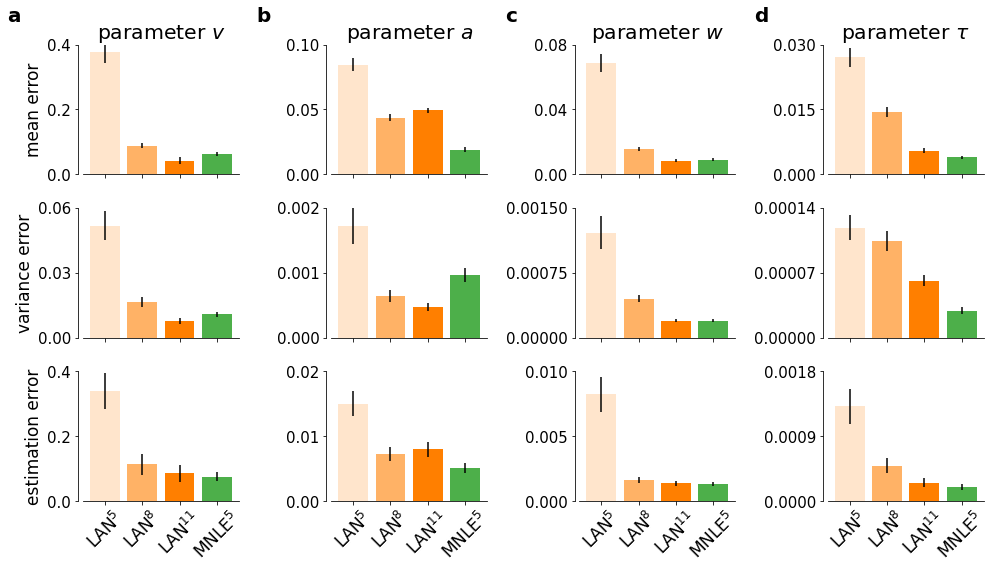

In [32]:
import numpy as np
fig, ax = plt.subplots(3, 4, figsize=(14, 8), sharey=False, sharex=True)
xlabels = [r"$v$", r"$a$", r"$w$", r"$\tau$"]
ylabels = ["mean error", "variance error", "estimation error"]
width = 0.08
pos = np.arange(.1, .41, .1)
ylimits = np.array([[.4, .1, .08, .03], [0.06, .002, .0015, 0.00014], [0.4, .02, .01, .0018]])

for jj in range(4):  # methods
    for ii in range(4):  # params
        plt.sca(ax[0, ii])
        plt.ylim(0, ylimits[0, ii])
        plt.yticks(np.linspace(0, ylimits[0, ii], 3))
        plot_bar(pos[jj], width, meanerr[:, jj, ii], label=labels[jj], color=plot_colors[jj+1], alpha=alphas[jj+1])
        if jj==0 and ii==0:
            plt.ylabel(ylabels[0])
            
        plt.sca(ax[1, ii])
        plt.ylim(0, ylimits[1, ii])
        plt.yticks(np.linspace(0, ylimits[1, ii], 3))
        plot_bar(pos[jj], width, varerr[:, jj, ii], label=labels[jj], color=plot_colors[jj+1], alpha=alphas[jj+1])
        if jj==0 and ii==0:
            plt.ylabel(ylabels[1])
            
        plt.sca(ax[2, ii])
        plt.ylim(0, ylimits[2, ii])
        plt.yticks(np.linspace(0, ylimits[2, ii], 3))
        plot_bar(pos[jj], width, estimation_error[:, jj, ii], label=labels[jj], color=plot_colors[jj+1], alpha=alphas[jj+1])
        if jj==0 and ii==0:
            plt.ylabel(ylabels[2])
    plt.sca(ax[2, jj])
    plt.xticks(pos, labels, rotation=45, fontsize=mpl.rcParams["axes.labelsize"])
    plt.sca(ax[0, jj])
    plt.title(f"parameter {xlabels[jj]}")

# add y axes offset
axis_setoff = -0.03
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].spines["left"].set_position(("axes", axis_setoff))
    
weight = "bold"
fontsize = 20
y1 = .97
x1 = 0.01
dx = 0.247
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 2*dx, y1, "c", fontsize=fontsize, fontweight=weight)
fig.text(x1 + 3*dx, y1, "d", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("figures/FigureA1-posterior-metrics-each-parameter.png", dpi=300, bbox_inches="tight");
fig.savefig("figures/Figure 3--figure supplement 1.pdf", dpi=400, bbox_inches="tight");